# FDRI catchment gauge record vs gridded data at Carreg Wen

The rain gauge record is from Carreg-wen, Pembrokeshire

## Table of contents
[1 Analysis](#1-Analysis)  

In [1]:
import datetime
import numpy as np
import polars as pl
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

# Functions and globals for analysis

In [2]:
def convert_time_to_hour_base(data, hour, time_col='time'):
    """For polars dataframes"""
    return data.with_columns(
                pl.datetime(
                    pl.col(time_col).dt.year(),
                    pl.col(time_col).dt.month(),
                    pl.col(time_col).dt.day(),
                    hour,
                    0,
                    0,
                ).alias(time_col)
            )

In [ ]:
RAIN_COL = "rain_mm"
NEARBY_THRESHOLD_M = 2500 # metres
START_DATE = datetime.datetime(year=1976, month=1, day=1, hour=9)
END_DATE = datetime.datetime(year=2010, month=1, day=1, hour=9)
OVERLAP_THRESHOLD = 365*3 # three years

# Load data

## Load CEH-GEAR

In [4]:
ceh_plynlimon = xr.open_dataset('../../../CEH_GEAR/ceh_1km_plynlimonregion_19760101_20101231.nc')
ceh_plynlimon = ceh_plynlimon.rename({'rainfall_amount': RAIN_COL})
ceh_plynlimon

<xarray.Dataset> Size: 810MB
Dimensions:   (time: 12784, y: 44, x: 45)
Coordinates:
  * x         (x) float64 360B 2.76e+05 2.77e+05 2.78e+05 ... 3.19e+05 3.2e+05
  * y         (y) float64 352B 2.58e+05 2.59e+05 2.6e+05 ... 3e+05 3.01e+05
  * time      (time) datetime64[ns] 102kB 1976-01-01 1976-01-02 ... 2010-12-31
Data variables:
    lat       (time, y, x) float64 202MB ...
    lon       (time, y, x) float64 202MB ...
    rain_mm   (time, y, x) float64 202MB ...
    min_dist  (time, y, x) float64 202MB ...
    crs       (time) int16 26kB ...
Attributes: (12/30)
    title:                CEH Gridded Estimates of Areal Rainfall (CEH - GEAR...
    institution:          CEH Wallingford - NERC
    source:               CEH - GEAR: dataset created using Natural Neighbour...
    description:          Daily rainfall 1km-gridded dataset created as part ...
    grid_mapping:         crs
    history:              Created Fri 2014-03-21 11:56:35
    ...                   ...
    version_comment:      The version number of each data file corresponds to...
    comment:              In line with standard UK convention, the rainfall o...
    reference:            Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, ...
    licence:              Licensing conditions apply (datalicensing@ceh.ac.uk)
    summary:              The CEH-GEAR dataset contains 1-km grids of daily a...
    id:                   5dc179dc-f692-49ba-9326-a6893a503f6e

## Load HadUK-Grid

In [13]:
haduk_plynlimon = xr.open_mfdataset(['../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19760101_19920831.nc',\
                 '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19920901_20091231.nc'])
haduk_plynlimon = haduk_plynlimon.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_plynlimon = haduk_plynlimon.drop_vars(('latitude', 'longitude'))
haduk_plynlimon

<xarray.Dataset> Size: 215MB
Dimensions:                       (time: 12419, y: 44, x: 45, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 99kB 1976-01-01T12:00...
  * y                             (y) float64 352B 2.585e+05 ... 3.015e+05
  * x                             (x) float64 360B 2.765e+05 ... 3.205e+05
Dimensions without coordinates: bnds
Data variables:
    rain_mm                       (time, y, x) float64 197MB dask.array<chunksize=(3044, 22, 23), meta=np.ndarray>
    transverse_mercator           (time) int32 50kB dask.array<chunksize=(6088,), meta=np.ndarray>
    time_bnds                     (time, bnds) datetime64[ns] 199kB dask.array<chunksize=(6088, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, y, bnds) float64 9MB dask.array<chunksize=(6088, 44, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (time, x, bnds) float64 9MB dask.array<chunksize=(6088, 45, 2), meta=np.ndarray>
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-05-17T13:12:49
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_rainfall
    source:         HadUK-Grid_v1.3.0.0
    title:          Gridded surface climate observations data for the UK
    version:        v20240514
    Conventions:    CF-1.7

## Load Gauge data

In [21]:
## monthly gauges and start and end times
plynlimon_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_used.csv', try_parse_dates=True)
plynlimon_monthly_gauges = convert_time_to_hour_base(plynlimon_monthly_gauges, hour=9, time_col='START_DATE')
plynlimon_monthly_gauges = convert_time_to_hour_base(plynlimon_monthly_gauges, hour=9, time_col='END_DATE')

In [22]:
# daily metadata
plynlimon_metadata = pl.read_csv('../gauge_data/mo_plynlimon_area_metadata.csv')
plynlimon_metadata = plynlimon_metadata.with_columns(
    pl.col("ID").is_in(plynlimon_monthly_gauges['ID']).alias('IS_MONTHLY_GAUGE')
)
plynlimon_metadata.head()

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH,IS_MONTHLY_GAUGE
i64,i64,str,str,i64,i64,i64,i64,str,bool
421169,9670,"""CWM BIGA""","""GB-GBN""",285900,289100,54,309,"""/BI/UK/GB/WAL/POWN/""",false
421192,9671,"""BANC-Y-GROES, GRONWEN""","""GB-GBN""",288400,289200,54,297,"""/BI/UK/GB/WAL/POWN/""",false
421222,9672,"""PEN-Y-BANC FARM""","""GB-GBN""",289500,287500,54,366,"""/BI/UK/GB/WAL/POWN/""",false
421234,16800,"""CLYWEDOG DAM""","""GB-GBN""",291018,287054,54,290,"""/BI/UK/GB/WAL/POWN/""",true
421271,9673,"""LLANIDLOES, ABERNANT""","""GB-GBN""",295500,284700,54,152,"""/BI/UK/GB/WAL/POWN/""",false


In [24]:
plynlimon_metadata['IS_MONTHLY_GAUGE'].value_counts()

IS_MONTHLY_GAUGE,count
bool,u32
true,50
false,130


In [26]:
## Load gauge data (QC'd version)
plynlimon_all_gauges = pl.read_csv('../gauge_data/mo_daily_plynlimon_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
plynlimon_all_gauges = convert_time_to_hour_base(plynlimon_all_gauges, hour=9)
plynlimon_all_gauges.head()

gauge_id,time,rain_mm_gauge,mo_flag
i64,datetime[μs],f64,i64
421234,1971-01-01 09:00:00,0.3,0
421234,1971-01-02 09:00:00,0.0,0
421234,1971-01-04 09:00:00,0.0,0
421234,1971-01-05 09:00:00,1.6,0
421234,1971-01-06 09:00:00,17.9,0


### load new Carreg Wen data

In [29]:
carreg_monthly_gauge = pl.read_csv('../gauge_data/carreg_wen_monthly_92to03.csv', try_parse_dates=True)
carreg_monthly_gauge.head()

ID,TIME,PRECIPITATION,MET_OFFICE_FLAG
i64,datetime[μs],f64,i64
420649,1992-01-31 00:00:00,173.0,0
420649,1992-02-29 00:00:00,202.0,0
420649,1992-03-31 00:00:00,435.0,0
420649,1992-04-30 00:00:00,222.0,0
420649,1992-05-31 00:00:00,126.0,0


In [ ]:
pl.read_csv('../gauge_data/plynlimon-jwk-2024-infilled_carreg_rf.csv', skip_lines=13,)

data,last,2010-12-30T09:00:00
str,f64,str
"""1976-01-02T09:00:00""",null,"""M"""
"""1976-01-03T09:00:00""",0.5,null
"""1976-01-04T09:00:00""",62.0,null
"""1976-01-05T09:00:00""",12.5,null
"""1976-01-06T09:00:00""",5.0,null
…,…,…
"""2010-12-27T09:00:00""",0.0,null
"""2010-12-28T09:00:00""",20.0,null
"""2010-12-29T09:00:00""",1.5,null


# Gauge class required for analysis

In [17]:
ALL_METADATA = plynlimon_metadata
ALL_GAUGE_DATA = plynlimon_all_gauges
CEH_DATA = ceh_plynlimon
HADUK_DATA = haduk_plynlimon

In [18]:
class Gauge:
    def __init__(self, gauge_id):
        self.gauge_id = int(gauge_id)
        self.gauge_metadata = self._get_gauge_metadata()
        self.gauge_easting = self.gauge_metadata['EASTING'].item()
        self.gauge_northing = self.gauge_metadata['NORTHING'].item()
        self.gauge_data = self._get_gauge_data()
        self.nearby_gauges = self._get_nearby_gauges()
        self.closest_cehgear = self._get_closest_gridded_data(CEH_DATA)
        self.closest_haduk = self._get_closest_gridded_data(HADUK_DATA)

    def _get_gauge_metadata(self):
        assert self.gauge_id in ALL_METADATA['ID'],\
            f"Gauge id={self.gauge_id} is not in the gauge metadata"
        return ALL_METADATA.filter(pl.col("ID") == self.gauge_id)

    def _get_gauge_data(self):
        assert self.gauge_id in ALL_GAUGE_DATA['gauge_id'],\
            f"Gauge id={self.gauge_id} is not in the gauge data"
        return ALL_GAUGE_DATA.filter(pl.col("gauge_id") == self.gauge_id)

    def _get_nearby_gauges(self, nearby_threshold_m=NEARBY_THRESHOLD_M):
        nearby_gauge_metadata = ALL_METADATA.filter((pl.col('EASTING') >= self.gauge_easting-nearby_threshold_m)\
                                                & (pl.col('EASTING') <= self.gauge_easting+nearby_threshold_m) &\
            (pl.col('NORTHING') >= self.gauge_northing-nearby_threshold_m) & (pl.col('NORTHING') <= self.gauge_northing+nearby_threshold_m))
        return nearby_gauge_metadata['ID'].to_list()

    def _get_closest_gridded_data(self, gridded_data, closeness_threshold_m=NEARBY_THRESHOLD_M):
        """TODO: needs testing with data that is off grid"""
        closest_grid_cell = gridded_data.sel(x=self.gauge_easting, y=self.gauge_northing, method='nearest')
        distance_x, distance_y = abs(self.gauge_easting-closest_grid_cell['x']), abs(self.gauge_northing-closest_grid_cell['y'])
        if distance_x > closeness_threshold_m or distance_y > closeness_threshold_m:
            raise ValueError(f"Closest data point in grid is more than {closeness_threshold_m} m away in X ({distance_x} m), or Y ({distance_y} m)")
        return closest_grid_cell

    def get_nearby_gridded_data(self, gridded_data, nearby_radius_m=NEARBY_THRESHOLD_M):
        nearby_grid_cells = gridded_data.sel(x=slice(self.gauge_easting-nearby_radius_m, self.gauge_easting+nearby_radius_m),\
                                y=slice(self.gauge_northing-nearby_radius_m, self.gauge_northing+nearby_radius_m))
        return nearby_grid_cells


def get_combined_gauge_data(gauge):
    assert isinstance(gauge, Gauge), "data should be of Gauge type"
    closest_ceh = pl.from_pandas(gauge.closest_cehgear[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_ceh').reset_index())
    closest_ceh = convert_time_to_hour_base(closest_ceh, hour=9)
    closest_haduk = pl.from_pandas(gauge.closest_haduk[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_haduk').reset_index())
    closest_haduk = convert_time_to_hour_base(closest_haduk, hour=9)
    combined_data = gauge.gauge_data[['time', f'{RAIN_COL}_gauge']].join(closest_ceh, on='time', how='left')
    combined_data = combined_data.join(closest_haduk, on='time', how='left')
    combined_data = combined_data.sort(by='time')
    return combined_data


def get_combined_gauge_data_w_nearby(gauge, nearby_radius_m=NEARBY_THRESHOLD_M):
    combined_data = get_combined_gauge_data(gauge)
    gauge.nearby_ceh = gauge.get_nearby_gridded_data(CEH_DATA, nearby_radius_m)
    gauge.nearby_haduk = gauge.get_nearby_gridded_data(HADUK_DATA, nearby_radius_m)
    nearby_ceh = pl.from_pandas(gauge.nearby_ceh[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_ceh').reset_index())
    nearby_ceh = convert_time_to_hour_base(nearby_ceh, hour=9)
    nearby_haduk = pl.from_pandas(gauge.nearby_haduk[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_haduk').reset_index())
    nearby_haduk = convert_time_to_hour_base(nearby_haduk, hour=9)
    combined_data = combined_data.join(nearby_ceh, on='time', how='left')
    combined_data = combined_data.join(nearby_haduk, on='time', how='left')
    combined_data = combined_data.sort(by='time')
    return combined_data

## Metrics to compare gauge to grid

In [ ]:
## calc_difference
def calc_difference_from_gauge(data, col):
    return data[f'{RAIN_COL}_gauge'] - data[col]

# Analysis

In [20]:
Gauge(420649)

In [41]:
plynlimon_annual_mean = plynlimon_rain_data.group_by_dynamic('time', every='1y').agg(pl.all().mean())
plynlimon_annual_sum = plynlimon_rain_data.group_by_dynamic('time', every='1y').agg(pl.all().sum())

plynlimon_annual_mean.head()

time,rain_mm_gauge,rain_mm_1cell_cehgear,rain_mm_mean_cehgear,rain_mm_1cell_haduk,rain_mm_mean_haduk
datetime[μs],f64,f64,f64,f64,f64
1976-01-01 00:00:00,5.061676,4.85,4.794811,5.052509,4.823164
1977-01-01 00:00:00,8.189726,7.748767,7.632481,7.894609,7.600082
1978-01-01 00:00:00,7.179452,6.888493,6.828341,7.211537,6.884219
1979-01-01 00:00:00,9.094521,7.919726,7.881826,8.194458,7.84368
1980-01-01 00:00:00,8.189891,7.392623,7.340498,7.725199,7.407256


In [46]:
annual_data_dir = {'mean': plynlimon_annual_mean, 'sum': plynlimon_annual_sum}
stat_to_examine = 'mean'

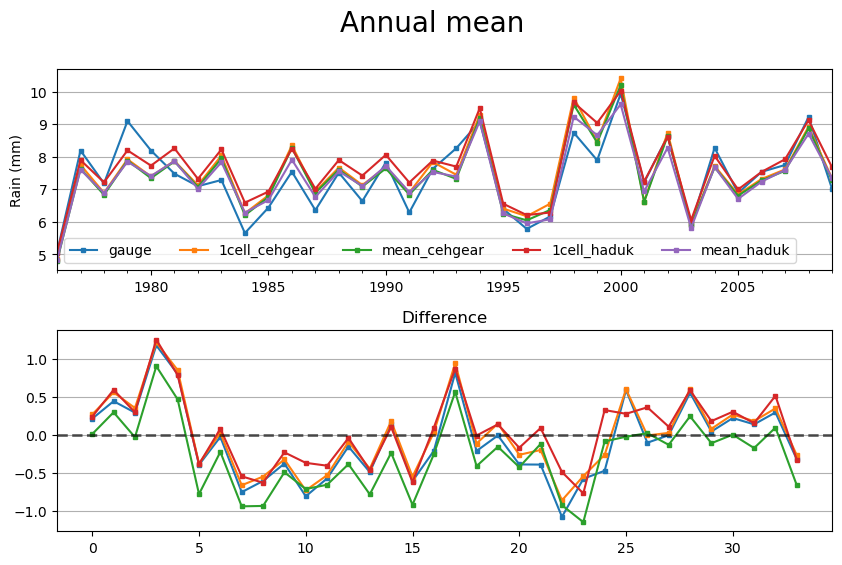

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
annual_data_dir[stat_to_examine].to_pandas().set_index('time').plot(marker='s', markersize=3, ax=axes[0])
for ind, col in enumerate(annual_data_dir[stat_to_examine].columns[2:]):
    axes[1].plot(calc_difference_from_gauge(annual_data_dir[stat_to_examine], col), marker='s', markersize=3, label=col, color=f'C{ind}')

axes[0].legend([col.split('rain_mm_')[-1] for col in annual_data_dir['mean'].columns[1:]], ncols=5)
axes[0].set_ylabel(f"Rain (mm)"); axes[0].set_xlabel('')

axes[1].set_title("Difference")
axes[1].axhline(0, color='k', linewidth=2, alpha=.6, linestyle='--')

for ax in axes:
    ax.grid(axis='y')
plt.suptitle(f"Annual {stat_to_examine}", size=20)
plt.subplots_adjust(hspace=.3)

# fig.savefig(f'../figures/annual_{stat_to_examine}_rainfall_comparison.png', bbox_inches='tight', dpi=200)

## double mass plot

In [48]:
plynlimon_rain_data_cumsum = plynlimon_rain_data.with_columns(
    pl.all().exclude("time").cum_sum()
)
plynlimon_rain_data_cumsum.tail()

time,rain_mm_gauge,rain_mm_1cell_cehgear,rain_mm_mean_cehgear,rain_mm_1cell_haduk,rain_mm_mean_haduk
datetime[μs],f64,f64,f64,f64,f64
2009-12-27 09:00:00,92069.25,93086.0,92087.755556,95371.906055,91353.209883
2009-12-28 09:00:00,92070.25,93086.3,92088.044444,95372.570642,91353.857227
2009-12-29 09:00:00,92070.25,93107.0,92108.4,95395.955159,91376.64373
2009-12-30 09:00:00,92070.25,93120.0,92121.411111,95409.865667,91390.215455
2009-12-31 09:00:00,92070.25,93120.0,92121.411111,95409.910847,91390.258224


In [49]:
var_to_examine, data_to_examine = '1cell', 'cehgear'
x_var = f'{RAIN_COL}_1cell_haduk'
y_var = f'{RAIN_COL}_{var_to_examine}_{data_to_examine}'

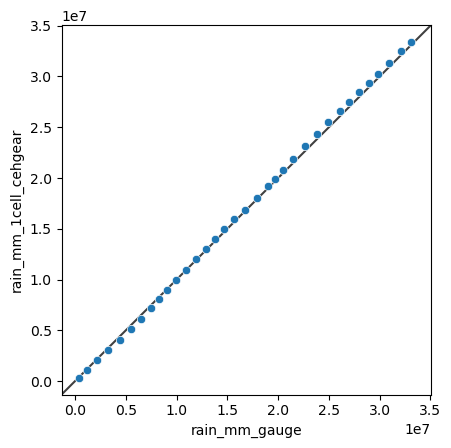

In [50]:
#  = carreg_rain_data_cumsum.group_by_dynamic('time', every='1y').agg(pl.all().sum())
data_to_plot = plynlimon_rain_data_cumsum.group_by_dynamic('time', every='12mo').agg(pl.all().sum())

fig, ax = plt.subplots(1)
sns.scatterplot(x='rain_mm_gauge', y=f'rain_mm_{var_to_examine}_{data_to_examine}', data=data_to_plot, ax=ax)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

# fig.savefig('../figures/double_mass_cehgear_gauge_annual.png', bbox_inches='tight', dpi=200)

## Look at flood events

In [51]:
## Severn-wide flood events (from: https://github.com/Thomasjkeel/FDRI-catchment-contribution-to-floods)
severn_flood_dates = ['2000-09-28', '2001-02-13', '2002-01-28', '2002-11-15', '2007-01-01', '2008-03-17','2008-11-11']
severn_flood_dates = [datetime.datetime.strptime(flood_date + ' 09:00', "%Y-%m-%d %H:%M") for flood_date in severn_flood_dates]

In [52]:
def get_date_ndays_before(one_date, ndays):
    return one_date-datetime.timedelta(days=ndays)

In [53]:
def get_data_ndays_before_flood_date(data, flood_date):
    days_before = get_date_ndays_before(flood_date, ndays=10)
    return data.filter(
        (pl.col("time") >= days_before) & (pl.col("time") <= flood_date)
    )

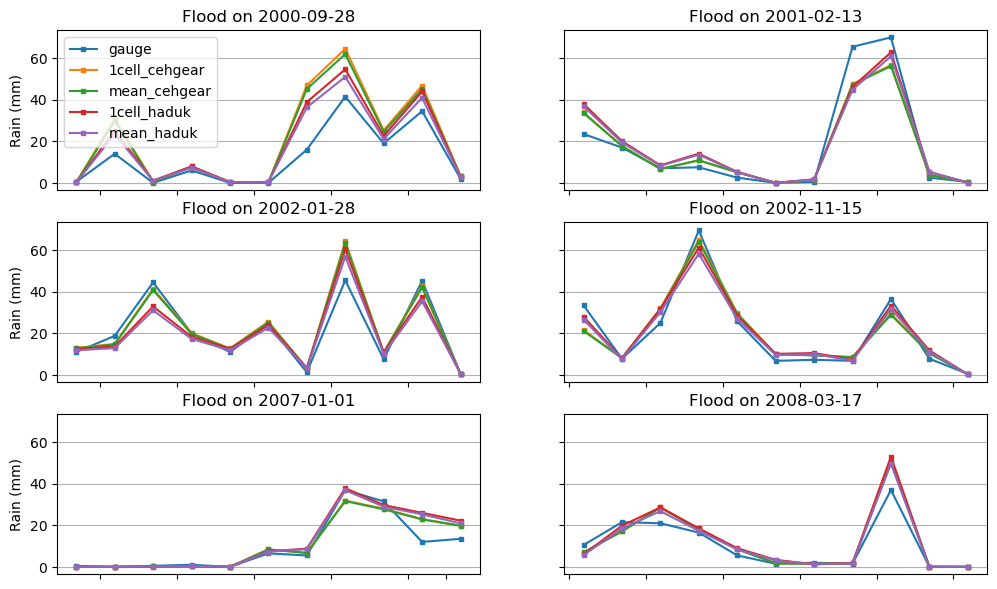

In [54]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharey=True)
for ind, ax in enumerate(axes.flatten()):
    if ind == 0:
        get_data_ndays_before_flood_date(plynlimon_rain_data, severn_flood_dates[ind]).to_pandas().set_index('time').plot(ax=ax, marker='s', markersize=3)
        ax.legend([col.split('rain_mm_')[-1] for col in annual_data_dir['mean'].columns[1:]])
    else:
        get_data_ndays_before_flood_date(plynlimon_rain_data, severn_flood_dates[ind]).to_pandas().set_index('time').plot(ax=ax, marker='s', markersize=3, legend=False)
    ax.set_title(f"Flood on {severn_flood_dates[ind].strftime('%Y-%m-%d')}")
    ax.set_xticklabels((''));
    ax.set_xlabel('')
    ax.set_ylabel('Rain (mm)')
    ax.grid(axis='y')
# fig.savefig('../figures/six_flood_comparison.png', bbox_inches='tight', dpi=200)

## Spatial variation of HADUK

In [24]:
dataset_dir = {'CEH-GEAR': ceh_plynlimon, 'HadUK-Grid': haduk_plynlimon}
dataset_to_examine = 'CEH-GEAR'

In [29]:
def plot_3by3_heatmap_mean_std(dataset, axes_row):
    dataset[RAIN_COL].mean('time').plot(cmap='Blues', ax=axes_row[0])
    axes_row[0].plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')
    axes_row[0].set_title('mean')

    dataset[RAIN_COL].std('time').plot(cmap='Purples', ax=axes_row[1])
    axes_row[1].plot(CARREG_COORDS['Easting'], CARREG_COORDS['Northing'], 'ro')
    axes_row[1].set_title('stdev')

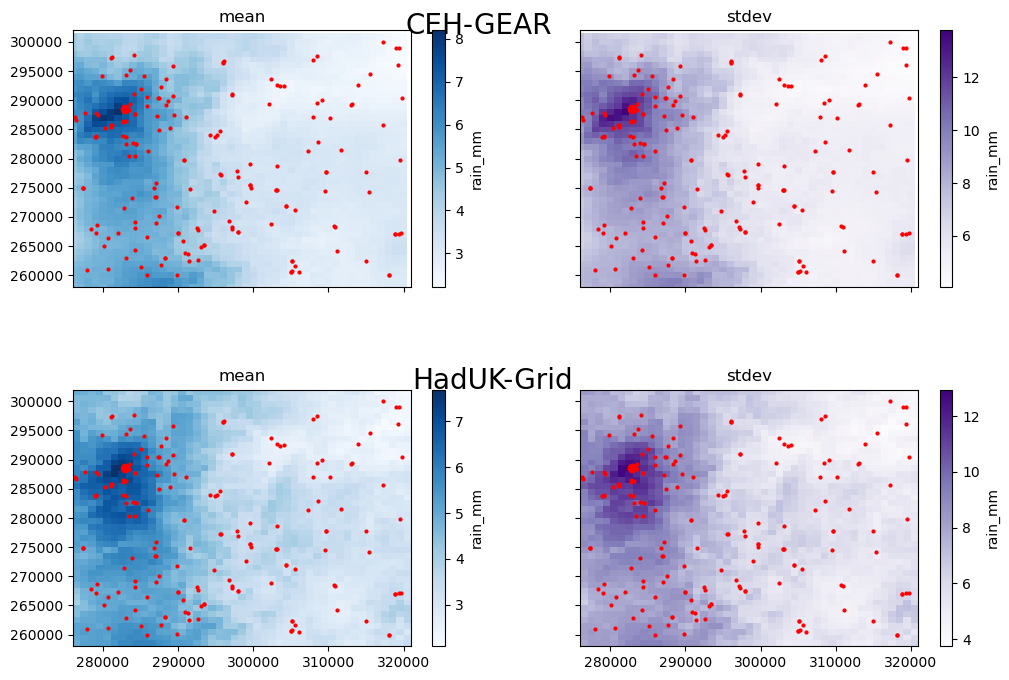

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
plot_3by3_heatmap_mean_std(dataset_dir['CEH-GEAR'], axes_row=axes[0])
plot_3by3_heatmap_mean_std(dataset_dir['HadUK-Grid'], axes_row=axes[1])

for ax in axes.flatten():
    ax.set_xlabel(''); ax.set_ylabel('')

axes[0][0].text(s='CEH-GEAR', x=dataset_dir['CEH-GEAR']['x'].max()+300,\
                              y=dataset_dir['CEH-GEAR']['y'].max()+300,\
                                size=20)

axes[1][0].text(s='HadUK-Grid', x=dataset_dir['HadUK-Grid']['projection_x_coordinate'].max()+700,\
                              y=dataset_dir['HadUK-Grid']['projection_y_coordinate'].max()+700,\
                                size=20)

for ax in axes.flatten():
  for plyn_row in plynlimon_metadata.iter_rows(named=True):
    ax.plot(plyn_row['EASTING'], plyn_row['NORTHING'], 'ro', markersize=2)

plt.subplots_adjust(hspace=.4)
# fig.savefig('../figures/ceh_vs_haduk_grid_comparison.png', bbox_inches='tight', dpi=200)